In [12]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Anomaly Detection
from sklearn.ensemble import IsolationForest
from scipy.stats import f_oneway



---



# *Data Wrangling and EDA.*

In [13]:
df = pd.read_csv(r"C:\Users\w0554\OneDrive\Desktop\bank.transactions.data.csv")
print(df.head())

  TransactionID AccountID  TransactionAmount   TransactionDate  \
0      TX000001   AC00128              14.09   4/11/2023 16:29   
1      TX000002   AC00455             376.24   6/27/2023 16:44   
2      TX000003   AC00019             126.29   7/10/2023 18:16   
3      TX000004   AC00070             184.50    5/5/2023 16:32   
4      TX000005   AC00411              13.45  10/16/2023 17:51   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81              1   


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [15]:
print(df.isnull().sum())

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


In [16]:
print(df.duplicated().sum())

0


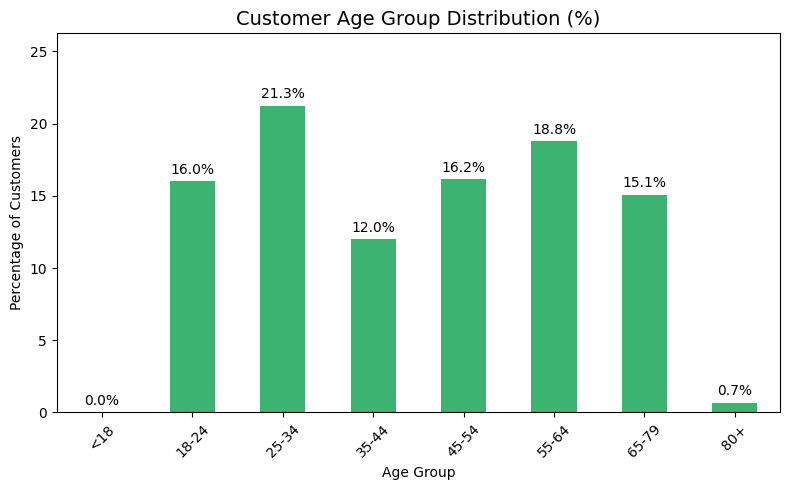

In [17]:
# Bin the ages into categories
age_bins = [0, 18, 25, 35, 45, 55, 65, 80, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-79', '80+']
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins=age_bins, labels=age_labels, right=False)

# Calculate proportion as percentage
age_distribution = df['AgeGroup'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(8, 5))
age_distribution.plot(kind='bar', color='mediumseagreen')

# Add percentage labels on top of bars
for i, val in enumerate(age_distribution):
    plt.text(i, val + 0.5, f'{val:.1f}%', ha='center', fontsize=10)

plt.title('Customer Age Group Distribution (%)', fontsize=14)
plt.ylabel('Percentage of Customers')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.ylim(0, age_distribution.max() + 5)
plt.tight_layout()
plt.show()

<Axes: xlabel='CustomerOccupation'>

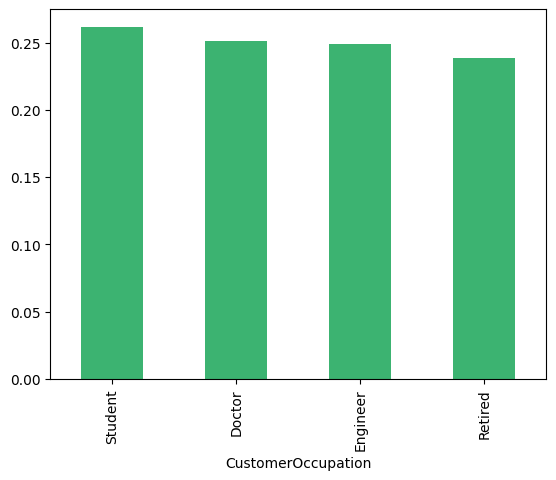

In [18]:
df['CustomerOccupation'].value_counts(normalize=True).plot(kind='bar', color='mediumseagreen')

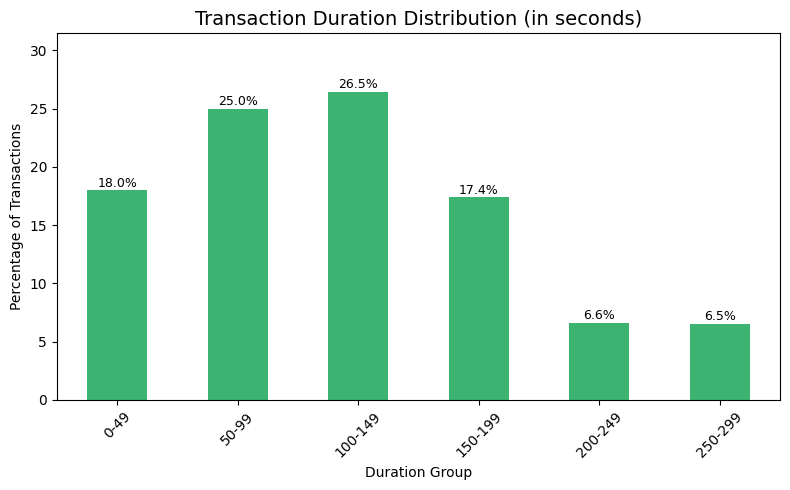

In [19]:
# Create bins (every 50 seconds)
duration_bins = list(range(0, 301, 50))
duration_labels = [f"{i}-{i+49}" for i in duration_bins[:-1]]

df['DurationGroup50'] = pd.cut(df['TransactionDuration'], bins=duration_bins, labels=duration_labels, right=False)

duration_distribution = df['DurationGroup50'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(8, 5))
duration_distribution.plot(kind='bar', color='mediumseagreen')

for i, val in enumerate(duration_distribution):
    plt.text(i, val + 0.3, f'{val:.1f}%', ha='center', fontsize=9)

plt.title('Transaction Duration Distribution (in seconds)', fontsize=14)
plt.ylabel('Percentage of Transactions')
plt.xlabel('Duration Group')
plt.xticks(rotation=45)
plt.ylim(0, duration_distribution.max() + 5)
plt.tight_layout()
plt.show()

<Axes: xlabel='TransactionType'>

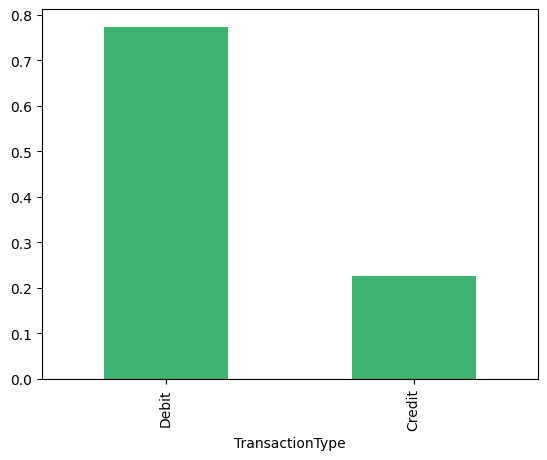

In [20]:
df['TransactionType'].value_counts(normalize=True).plot(kind='bar', color='mediumseagreen')

<Axes: xlabel='Channel'>

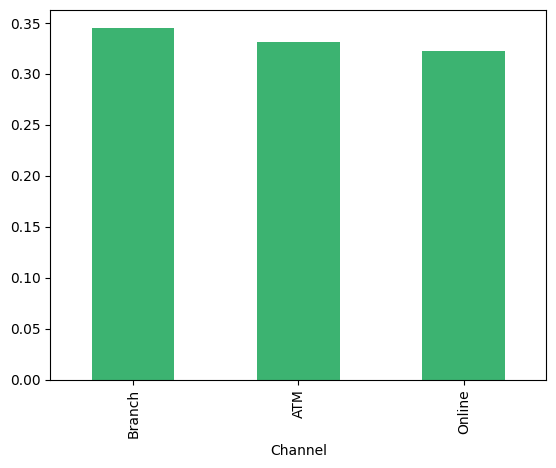

In [21]:
df['Channel'].value_counts(normalize=True).plot(kind='bar', color='mediumseagreen')

In [22]:
# Check for unrealistic values in numeric columns
numeric_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

print("Summary Statistics for Numeric Columns:")
print(df[numeric_cols].describe())

# Check for negative or zero values where they don't make sense
for col in ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts']:
    if (df[col] <= 0).any():
        print(f"Warning: {col} contains {(df[col] <= 0).sum()} non-positive values.")
        print(df[df[col] <= 0][col])

# Check for outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
    return outliers

for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"\nOutliers in {col}: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers.head())

Summary Statistics for Numeric Columns:
       TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
std           291.946243    17.792198            69.963757       0.602662   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance  
count     2512.000000  
mean      5114.302966  
std       3900.942499  
min        101.250000  
25%       1504.370000  
50%       4735.510000  
75%       7678.820000  
max      14977.990000  

Outliers in TransactionAmount: 113
74     1212.51

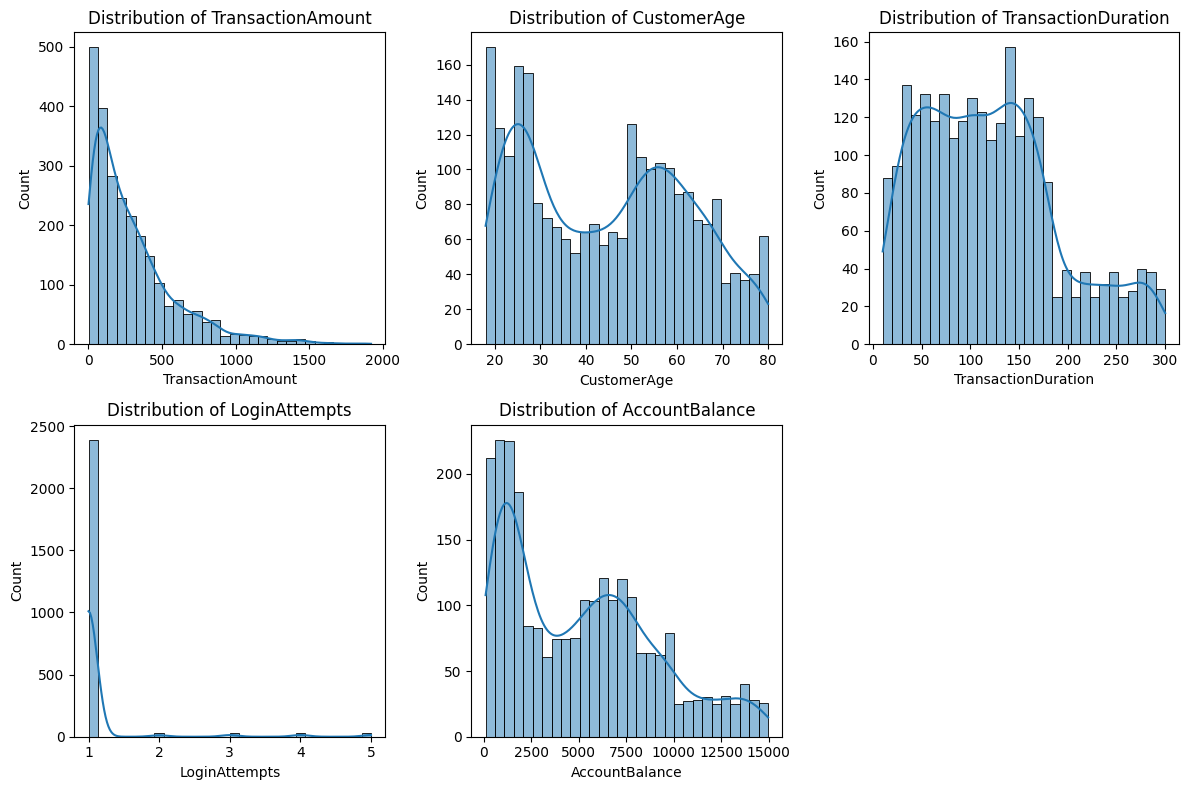

In [23]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [24]:
# Check categorical variables for unexpected categories
categorical_cols = ['TransactionType', 'Channel', 'CustomerOccupation', 'Location']
for col in categorical_cols:
    print(f"Unique values in {col}: {df[col].unique()}")
    if df[col].nunique() > 50:  # Arbitrary threshold for synthetic data issues
        print(f"Warning: {col} has {df[col].nunique()} unique values, which may indicate synthetic artifacts.")

# Check for date consistency
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
if df['TransactionDate'].isnull().any():
    print(f"Warning: {df['TransactionDate'].isnull().sum()} invalid dates found.")
else:
    print("All TransactionDate values are valid.")
print(f"Date range: {df['TransactionDate'].min()} to {df['TransactionDate'].max()}")

Unique values in TransactionType: ['Debit' 'Credit']
Unique values in Channel: ['ATM' 'Online' 'Branch']
Unique values in CustomerOccupation: ['Doctor' 'Student' 'Retired' 'Engineer']
Unique values in Location: ['San Diego' 'Houston' 'Mesa' 'Raleigh' 'Atlanta' 'Oklahoma City'
 'Seattle' 'Indianapolis' 'Detroit' 'Nashville' 'Albuquerque' 'Memphis'
 'Louisville' 'Denver' 'Austin' 'Columbus' 'Los Angeles' 'Las Vegas'
 'Fort Worth' 'Miami' 'Milwaukee' 'Baltimore' 'New York' 'San Francisco'
 'San Jose' 'San Antonio' 'Philadelphia' 'Charlotte' 'Tucson' 'Chicago'
 'Sacramento' 'Kansas City' 'Omaha' 'Virginia Beach' 'Dallas' 'Boston'
 'Jacksonville' 'Phoenix' 'Washington' 'El Paso' 'Colorado Springs'
 'Fresno' 'Portland']
All TransactionDate values are valid.
Date range: 2023-01-02 16:00:00 to 2024-01-01 18:21:00




---



# *Clustering: Kmeans Algorithm.*

In [25]:
# Scaling to transforms data to a uniform distribution
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
data_numeric = df[numeric_cols]

In [26]:
categorical_cols = ['TransactionType', 'Channel', 'CustomerOccupation']

# Create dummy variables
encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

In [27]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract features
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek   # Monday = 0
df['IsWeekend'] = df['DayOfWeek'] >= 5                  # Saturday/Sunday = 1

df['Day'] = df['TransactionDate'].dt.day
df['Month'] = df['TransactionDate'].dt.month

In [28]:
print(f"Unique hour values: {df['Hour'].unique()}")  # To see the unique hours
print(f"\nUnique transaction dates: {df['TransactionDate'].unique()}") # To see unique transaction dates

Unique hour values: [16 18 17]

Unique transaction dates: <DatetimeArray>
['2023-04-11 16:29:00', '2023-06-27 16:44:00', '2023-07-10 18:16:00',
 '2023-05-05 16:32:00', '2023-10-16 17:51:00', '2023-04-03 17:15:00',
 '2023-02-15 16:36:00', '2023-05-08 17:47:00', '2023-03-21 16:59:00',
 '2023-03-31 16:06:00',
 ...
 '2023-04-21 16:22:00', '2023-11-06 16:56:00', '2024-01-01 17:21:00',
 '2023-01-27 17:38:00', '2023-04-13 17:45:00', '2023-04-26 17:09:00',
 '2023-03-22 17:36:00', '2023-08-21 17:08:00', '2023-02-24 16:24:00',
 '2023-02-14 16:21:00']
Length: 2405, dtype: datetime64[ns]


In [29]:
full_data = pd.concat([
    df[['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'Hour', 'DayOfWeek']],
    pd.get_dummies(df[['TransactionType', 'Channel', 'CustomerOccupation']], drop_first=True)
], axis=1)

# Scale the full feature matrix
scaler = StandardScaler()
scaled_df = scaler.fit_transform(full_data)

K=2, Silhouette Score: 0.173, Inertia: 27519.01
K=3, Silhouette Score: 0.188, Inertia: 24079.26
K=4, Silhouette Score: 0.195, Inertia: 22094.56
K=5, Silhouette Score: 0.202, Inertia: 20230.42
K=6, Silhouette Score: 0.183, Inertia: 19285.57
K=7, Silhouette Score: 0.170, Inertia: 18606.53
K=8, Silhouette Score: 0.156, Inertia: 17913.71
K=9, Silhouette Score: 0.162, Inertia: 17219.42
K=10, Silhouette Score: 0.160, Inertia: 16740.13


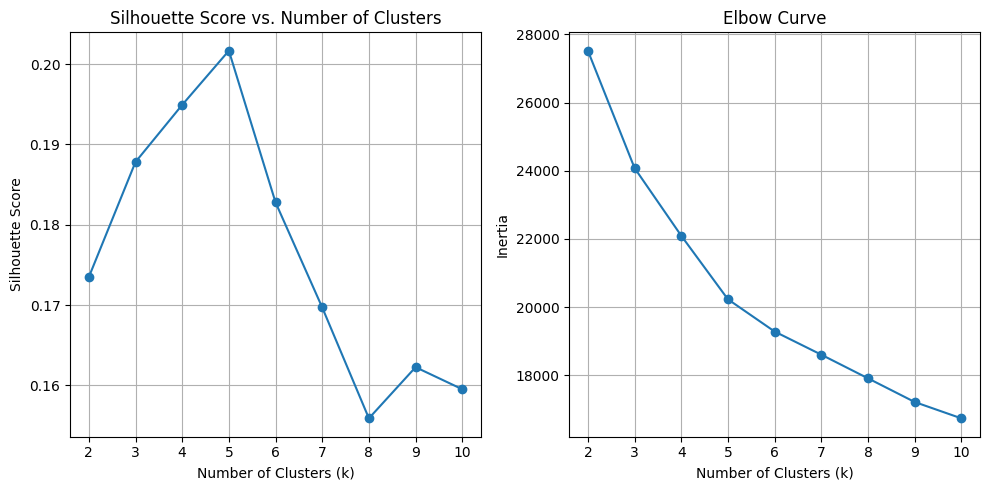

Optimal k: 5 (based on silhouette score)


In [30]:
# K-Means: Tune number of clusters (k) using silhouette score
k_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_df)
    silhouette = silhouette_score(scaled_df, clusters)
    silhouette_scores.append(silhouette)
    inertia_scores.append(kmeans.inertia_)
    print(f"K={k}, Silhouette Score: {silhouette:.3f}, Inertia: {kmeans.inertia_:.2f}")

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Plot elbow curve
plt.subplot(1, 2, 2)
plt.plot(k_range, inertia_scores, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select optimal k based on highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k: {optimal_k} (based on silhouette score)")

In [31]:
k = 5 # Chosen based on the Elbow Plot
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_df)

df['Cluster'] = clusters

print("\nData with cluster labels:")
print(df[['Cluster'] + list(numeric_cols) + list(categorical_cols)].head(3))

score = silhouette_score(scaled_df, clusters)
print(f"\nSilhouette Score: {score:.3f}")


Data with cluster labels:
   Cluster  TransactionAmount  CustomerAge  TransactionDuration  \
0        1              14.09           70                   81   
1        1             376.24           68                  141   
2        2             126.29           19                   56   

   LoginAttempts  AccountBalance TransactionType Channel CustomerOccupation  
0              1         5112.21           Debit     ATM             Doctor  
1              1        13758.91           Debit     ATM             Doctor  
2              1         1122.35           Debit  Online            Student  

Silhouette Score: 0.202


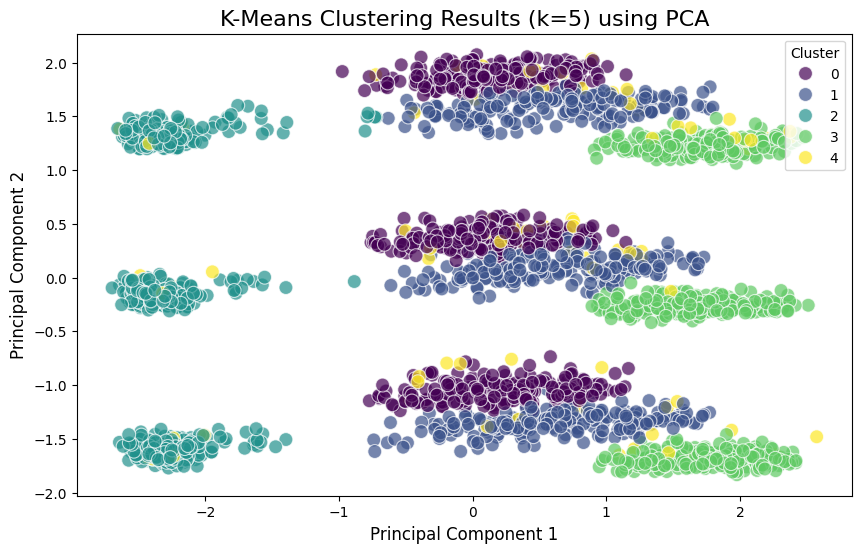

In [32]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df['Cluster'] = kmeans.labels_
pca_df['Cluster'] = df['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title(f'K-Means Clustering Results (k={k}) using PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

plt.legend(title='Cluster', loc='best')
plt.show()

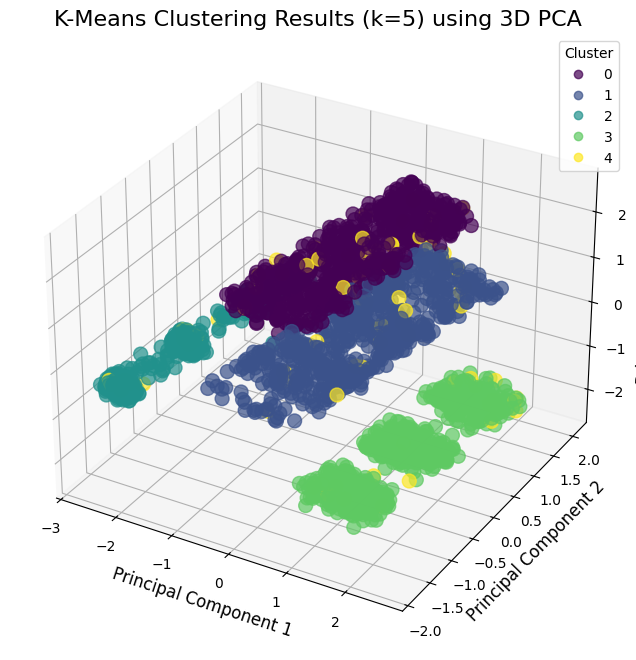

In [33]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])
df['Cluster'] = kmeans.labels_
pca_df['Cluster'] = df['Cluster']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
ax.set_title(f'K-Means Clustering Results (k={k}) using 3D PCA', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)

legend = ax.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [34]:
# Add cluster labels to the dataframe
df['Cluster'] = kmeans.labels_

# Count how many points in each cluster
df['Cluster'].value_counts()

Cluster
2    641
0    600
1    598
3    578
4     95
Name: count, dtype: int64

In [35]:
df.groupby('Cluster')[['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']].describe()


TransactionAmount                                                  \
                    count        mean         std   min      25%      50%   
Cluster                                                                     
0                   600.0  289.674967  283.704725  0.32  87.2825  212.050   
1                   598.0  291.541505  294.424892  1.14  77.5175  195.305   
2                   641.0  315.025211  304.102322  0.26  87.3800  217.610   
3                   578.0  296.240138  287.070794  1.21  79.9575  213.580   
4                    95.0  276.324316  273.282522  1.93  89.7850  180.650   

                          CustomerAge             ... LoginAttempts       \
             75%      max       count       mean  ...           75%  max   
Cluster                                           ...                      
0        406.660  1830.00       600.0  42.690000  ...           1.0  2.0   
1        409.605  1919.11       598.0  49.794314  ...           1.0  2.0   
2        431.310  1762.28       641.0  23.202808  ...           1.0  2.0   
3        391.740  1647.74       578.0  65.269896  ...           1.0  2.0   
4        380.145  1531.31        95.0  44.536842  ...           5.0  5.0   

        AccountBalance                                                \
                 count         mean          std      min        25%   
Cluster                                                                
0                600.0  5490.606883  2745.313728   112.76  3020.4475   
1                598.0  9024.364465  4045.945778   120.89  6687.6975   
2                641.0  1579.070764  1924.150923   101.25   587.1100   
3                578.0  4541.789827  2043.947896  1006.12  2652.2475   
4                 95.0  5461.643053  4257.569517   271.78  1493.5850   

                                         
              50%         75%       max  
Cluster                                  
0        5673.760   7836.4450   9983.36  
1        9665.830  12259.8775  14977.99  
2        1084.650   1636.3200   9963.39  
3        4558.995   6321.3725   7996.70  
4        4976.180   8369.6950  14851.28  

[5 rows x 40 columns]

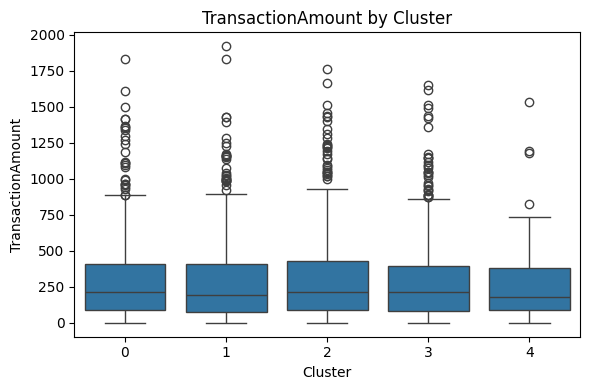

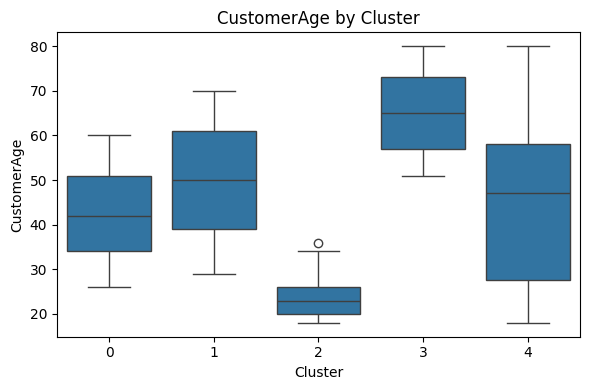

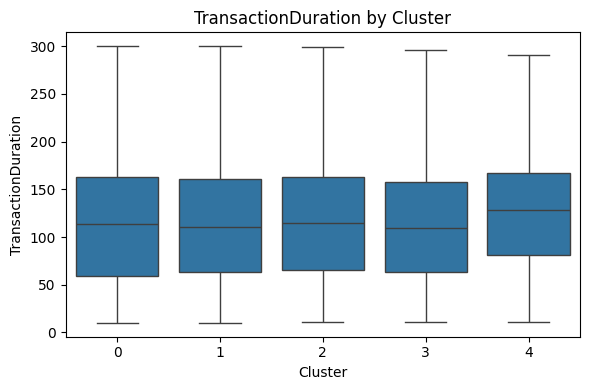

In [36]:
for col in ['TransactionAmount', 'CustomerAge', 'TransactionDuration']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Cluster', y=col, data=df)
    plt.title(f'{col} by Cluster')
    plt.tight_layout()
    plt.show()

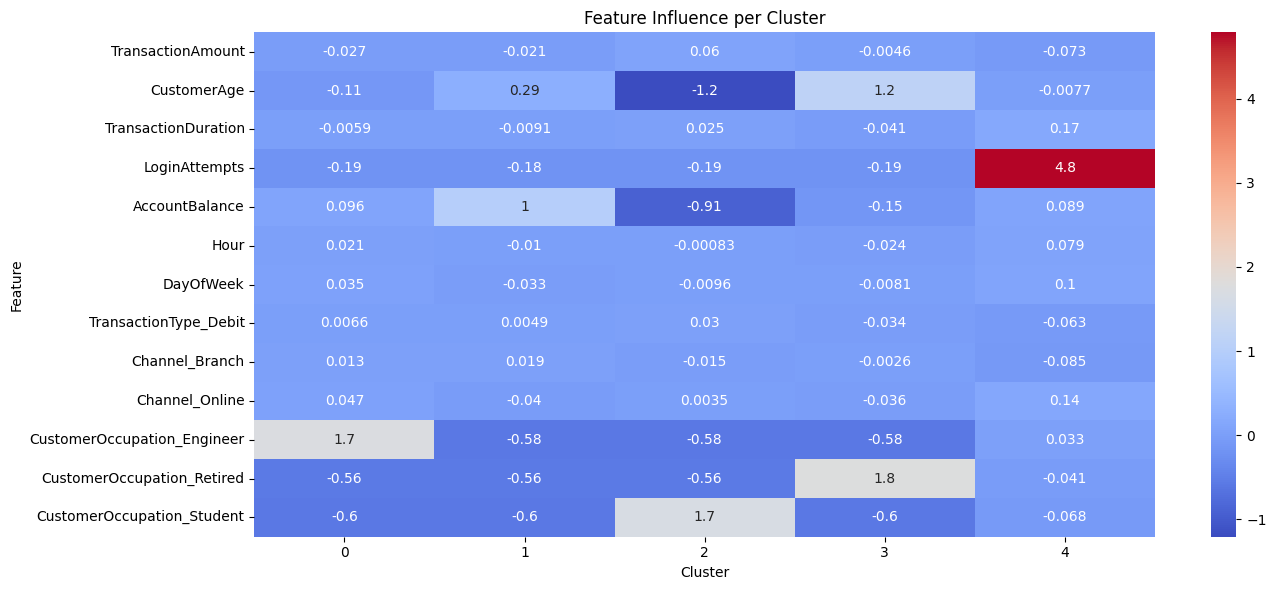

In [37]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=full_data.columns)
cluster_centers['Cluster'] = cluster_centers.index
cluster_centers = cluster_centers.set_index('Cluster')

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_centers.T, cmap='coolwarm', annot=True)
plt.title("Feature Influence per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [38]:
cluster_profile = df.groupby('Cluster')[[
    'TransactionAmount', 'CustomerAge', 'TransactionDuration',
    'LoginAttempts', 'AccountBalance'
]].mean().round(2)

cluster_profile['Count'] = df['Cluster'].value_counts().sort_index()
cluster_profile

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,Count
Cluster,,,,,,
0,289.67,42.69,119.23,1.01,5490.61,600
1,291.54,49.79,119.01,1.01,9024.36,598
2,315.03,23.20,121.42,1.01,1579.07,641
3,296.24,65.27,116.74,1.01,4541.79,578
4,276.32,44.54,131.88,4.01,5461.64,95




---



# *Anomoly Detection: Isolation Forest.*

In [39]:
iso = IsolationForest(contamination=0.05, random_state=42)
df['AnomalyScore'] = iso.fit_predict(scaled_df)

# -1 = anomaly, 1 = normal
df['IsAnomaly'] = df['AnomalyScore'] == -1

In [40]:
df['IsAnomaly'].value_counts()

IsAnomaly
False    2386
True      126
Name: count, dtype: int64

In [41]:
pd.crosstab(df['Cluster'], df['IsAnomaly'])

IsAnomaly,False,True
Cluster,,
0,571,29
1,586,12
2,628,13
3,557,21
4,44,51


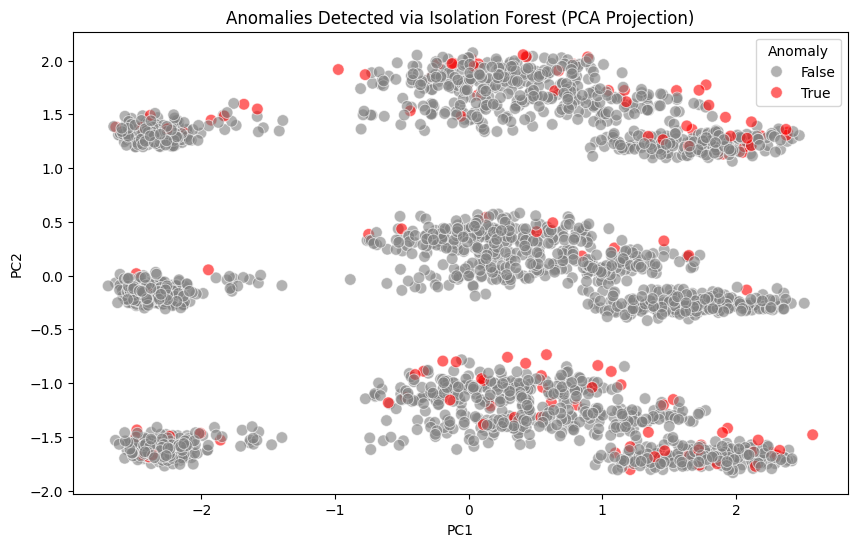

In [42]:
pca_df['IsAnomaly'] = df['IsAnomaly']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='IsAnomaly',
    data=pca_df,
    palette={True: 'red', False: 'grey'},
    s=70, alpha=0.6
)
plt.title('Anomalies Detected via Isolation Forest (PCA Projection)')
plt.legend(title='Anomaly')
plt.show()



---



In [43]:
for col in ['TransactionAmount', 'CustomerAge', 'TransactionDuration']:
    groups = [df[df['Cluster'] == k][col] for k in df['Cluster'].unique()]
    stat, p = f_oneway(*groups)
    print(f"{col}: p = {p:.4f}")

TransactionAmount: p = 0.4781
CustomerAge: p = 0.0000
TransactionDuration: p = 0.3567


<Axes: xlabel='Hour', ylabel='TransactionAmount'>

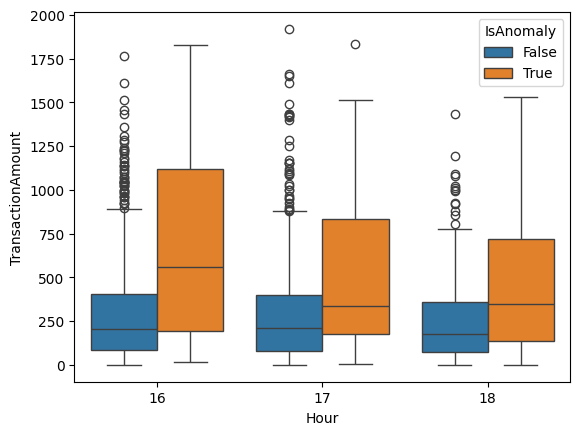

In [44]:
sns.boxplot(x='Hour', y='TransactionAmount', hue='IsAnomaly', data=df)



---



In [45]:
df['State'] = df['Location'].map({
    'Houston': 'TX',
    'Atlanta': 'GA',
    'San Diego': 'CA',
    'Mesa': 'AZ',
    'Raleigh': 'NC',
    'Los Angeles': 'CA',
    'New York': 'NY',
    'Chicago': 'IL',
    'Phoenix': 'AZ',
    'Philadelphia': 'PA',
    'San Antonio': 'TX',
    'Dallas': 'TX',
    'San Jose': 'CA',
    'Austin': 'TX',
    'Jacksonville': 'FL',
    'Fort Worth': 'TX',
    'Columbus': 'OH',
    'Charlotte': 'NC',
    'San Francisco': 'CA',
    'Indianapolis': 'IN',
    'Seattle': 'WA',
    'Denver': 'CO',
    'Washington': 'DC',
    'Boston': 'MA',
    'El Paso': 'TX',
    'Nashville': 'TN',
    'Detroit': 'MI',
    'Oklahoma City': 'OK',
    'Portland': 'OR',
    'Las Vegas': 'NV',
    'Memphis': 'TN',
    'Louisville': 'KY',
    'Baltimore': 'MD',
    'Milwaukee': 'WI',
    'Albuquerque': 'NM',
    'Tucson': 'AZ',
    'Fresno': 'CA',
    'Sacramento': 'CA',
    'Mesa': 'AZ',
    'Kansas City': 'MO',
    'Colorado Springs': 'CO',
    'Miami': 'FL',
    'Omaha': 'NE',
    'Arlington': 'TX',
    'Cleveland': 'OH',
    'Tampa': 'FL',
    'New Orleans': 'LA',
    'Wichita': 'KS',
    'Bakersfield': 'CA',
    'Virginia Beach': 'VA',
})

state_counts = df['State'].value_counts().reset_index()
state_counts.columns = ['State', 'TransactionCount']

fig = px.choropleth(
    state_counts,
    locations='State',
    locationmode='USA-states',
    color='TransactionCount',
    scope='usa',
    color_continuous_scale='Blues',
    title='Transaction Count by State'
)
fig.show()

In [46]:
# Filter only anomalies
anomaly_df = df[df['IsAnomaly'] == True]

# Count anomalies by state
anomaly_counts = anomaly_df['State'].value_counts().reset_index()
anomaly_counts.columns = ['State', 'AnomalyCount']

fig = px.choropleth(
    anomaly_counts,
    locations='State',
    locationmode='USA-states',
    color='AnomalyCount',
    scope='usa',
    color_continuous_scale='Reds',
    title='Anomaly Count by State (Isolation Forest)'
)
fig.show()

In [47]:
# Count total transactions per state
total_counts = df['State'].value_counts().reset_index()
total_counts.columns = ['State', 'TotalTx']

# Merge with anomalies
anomaly_rate = pd.merge(anomaly_counts, total_counts, on='State')
anomaly_rate['AnomalyRate'] = anomaly_rate['AnomalyCount'] / anomaly_rate['TotalTx']

fig = px.choropleth(
    anomaly_rate,
    locations='State',
    locationmode='USA-states',
    color='AnomalyRate',
    scope='usa',
    color_continuous_scale='peach',
    title='Anomaly Rate by State'
)
fig.show()

In [48]:
df[df['IsAnomaly'] == True].sort_values(by='AnomalyScore', ascending=False).head(5)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,...,DurationGroup50,Hour,DayOfWeek,IsWeekend,Day,Month,Cluster,AnomalyScore,IsAnomaly,State
19,TX000020,AC00285,71.48,2023-06-08 18:18:00,Credit,Columbus,D000039,120.170.93.69,M039,Online,...,150-199,18,3,False,8,6,2,-1,True,OH
25,TX000026,AC00041,7.49,2023-10-20 17:53:00,Credit,Houston,D000671,81.248.235.147,M043,Online,...,250-299,17,4,False,20,10,3,-1,True,TX
73,TX000074,AC00110,233.92,2023-10-20 16:54:00,Credit,Jacksonville,D000295,152.140.239.181,M046,Online,...,250-299,16,4,False,20,10,2,-1,True,FL
85,TX000086,AC00098,1340.19,2023-09-29 17:22:00,Credit,Austin,D000574,165.114.224.47,M012,Online,...,0-49,17,4,False,29,9,0,-1,True,TX
101,TX000102,AC00018,98.54,2023-08-11 16:18:00,Credit,El Paso,D000528,34.125.226.63,M095,Online,...,150-199,16,4,False,11,8,2,-1,True,TX


In [49]:
df.groupby('IsAnomaly')[['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'CustomerAge']].mean()

,TransactionAmount,TransactionDuration,LoginAttempts,CustomerAge
IsAnomaly,,,,
False,284.489656,119.053646,1.059095,44.463118
True,545.740079,130.809524,2.365079,48.666667


<Axes: xlabel='IsAnomaly', ylabel='TransactionAmount'>

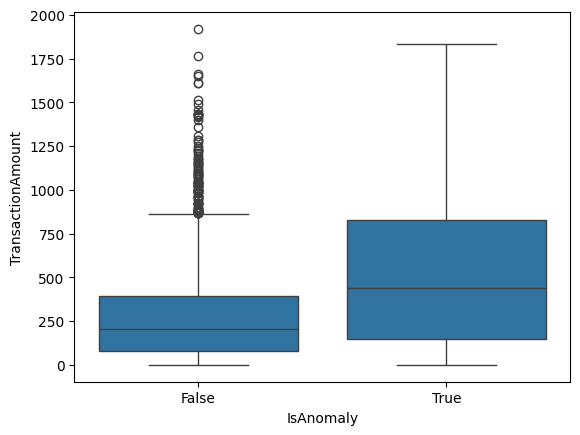

In [50]:
sns.boxplot(x='IsAnomaly', y='TransactionAmount', data=df)

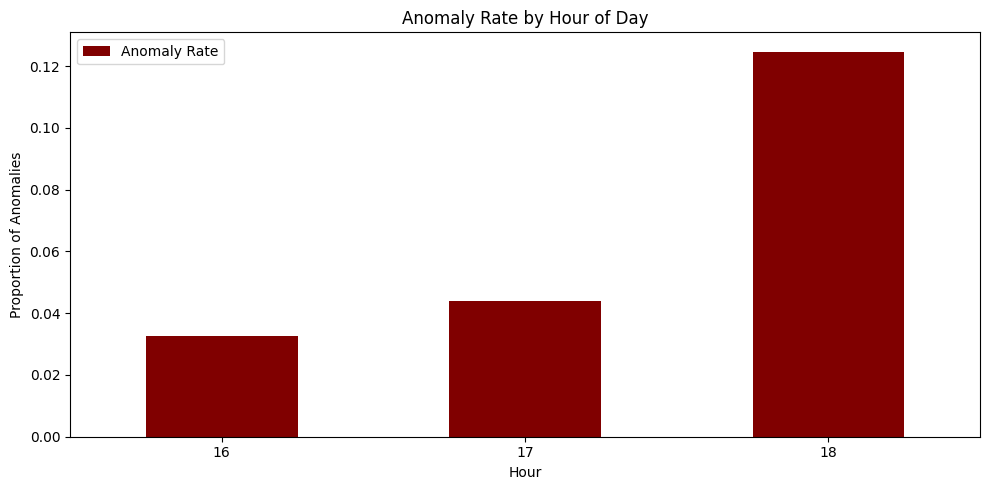

In [51]:
hourly = df.groupby('Hour')['IsAnomaly'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(10, 5))
hourly[True].plot(kind='bar', color='maroon', label='Anomaly Rate')
plt.title('Anomaly Rate by Hour of Day')
plt.ylabel('Proportion of Anomalies')
plt.xlabel('Hour')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Axes: xlabel='Channel'>

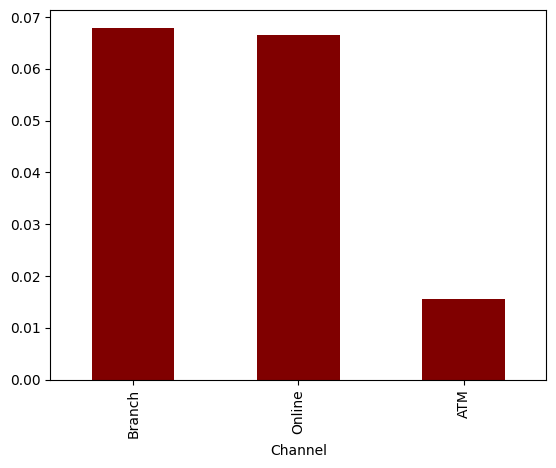

In [52]:
fraud_rate_by_channel = df.groupby('Channel')['IsAnomaly'].mean().sort_values(ascending=False)
fraud_rate_by_channel.plot(kind='bar', color='maroon')

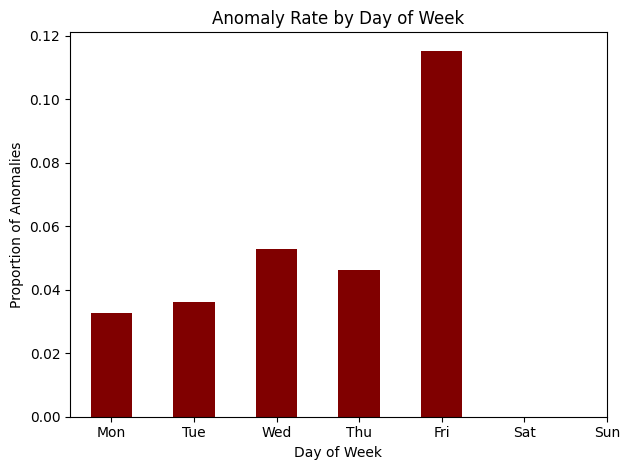

In [53]:
day_of_week_anomaly_counts = df.groupby('DayOfWeek')['IsAnomaly'].value_counts(normalize=True).unstack().fillna(0)

day_of_week_anomaly_counts[True].plot(kind='bar', color='maroon')
plt.title('Anomaly Rate by Day of Week')
plt.ylabel('Proportion of Anomalies')
plt.xlabel('Day of Week')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

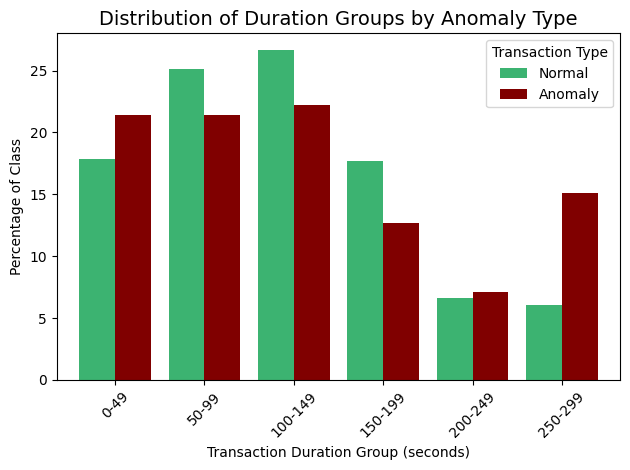

In [54]:
# Create bins (every 50 seconds)
duration_bins = list(range(0, 301, 50))
duration_labels = [f"{i}-{i+49}" for i in duration_bins[:-1]]

# Create a crosstab to count transactions in each bin, split by anomaly status
duration_anomaly_dist = pd.crosstab(df['DurationGroup50'], df['IsAnomaly'])

# Normalize within each column
duration_anomaly_percent = duration_anomaly_dist.div(duration_anomaly_dist.sum(axis=0), axis=1) * 100

plt.figure(figsize=(10, 6))
duration_anomaly_percent.plot(kind='bar', width=0.8, color=['mediumseagreen', 'maroon'])

plt.title('Distribution of Duration Groups by Anomaly Type', fontsize=14)
plt.ylabel('Percentage of Class')
plt.xlabel('Transaction Duration Group (seconds)')
plt.xticks(rotation=45)
plt.legend(['Normal', 'Anomaly'], title='Transaction Type')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

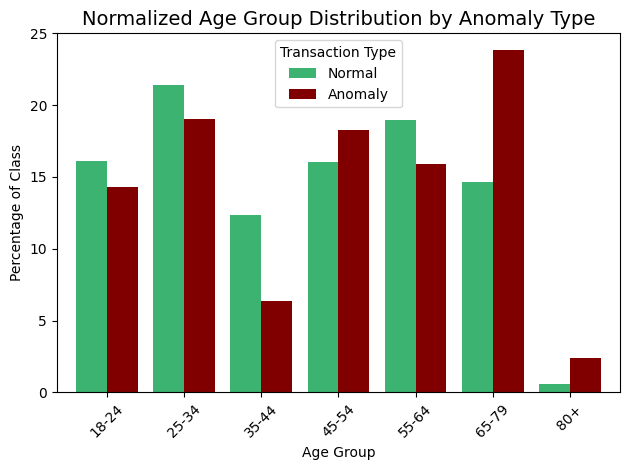

In [55]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 80, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-79', '80+']
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins=age_bins, labels=age_labels, right=False)

age_anomaly_dist = pd.crosstab(df['AgeGroup'], df['IsAnomaly'])

age_anomaly_percent = age_anomaly_dist.div(age_anomaly_dist.sum(axis=0), axis=1) * 100

plt.figure(figsize=(10, 6))
age_anomaly_percent.plot(kind='bar', width=0.8, color=['mediumseagreen', 'maroon'])

plt.title('Normalized Age Group Distribution by Anomaly Type', fontsize=14)
plt.ylabel('Percentage of Class')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.legend(['Normal', 'Anomaly'], title='Transaction Type')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

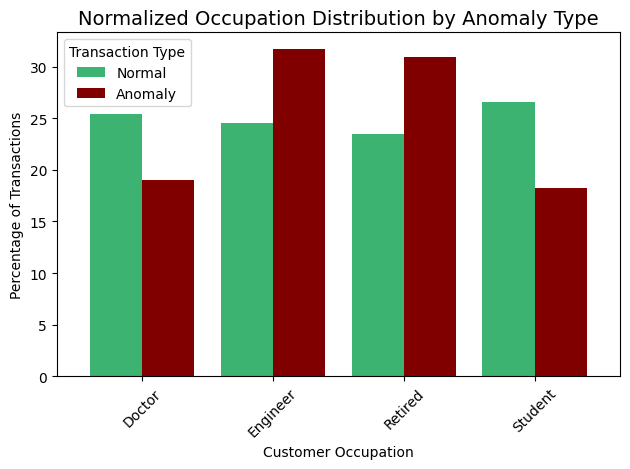

In [56]:
occupation_anomaly_dist = pd.crosstab(df['CustomerOccupation'], df['IsAnomaly'])

occupation_anomaly_percent = occupation_anomaly_dist.div(occupation_anomaly_dist.sum(axis=0), axis=1) * 100

plt.figure(figsize=(10, 6))
occupation_anomaly_percent.plot(kind='bar', color=['mediumseagreen', 'maroon'], width=0.8)

plt.title('Normalized Occupation Distribution by Anomaly Type', fontsize=14)
plt.ylabel('Percentage of Transactions')
plt.xlabel('Customer Occupation')
plt.xticks(rotation=45)
plt.legend(['Normal', 'Anomaly'], title='Transaction Type')
plt.tight_layout()
plt.show()

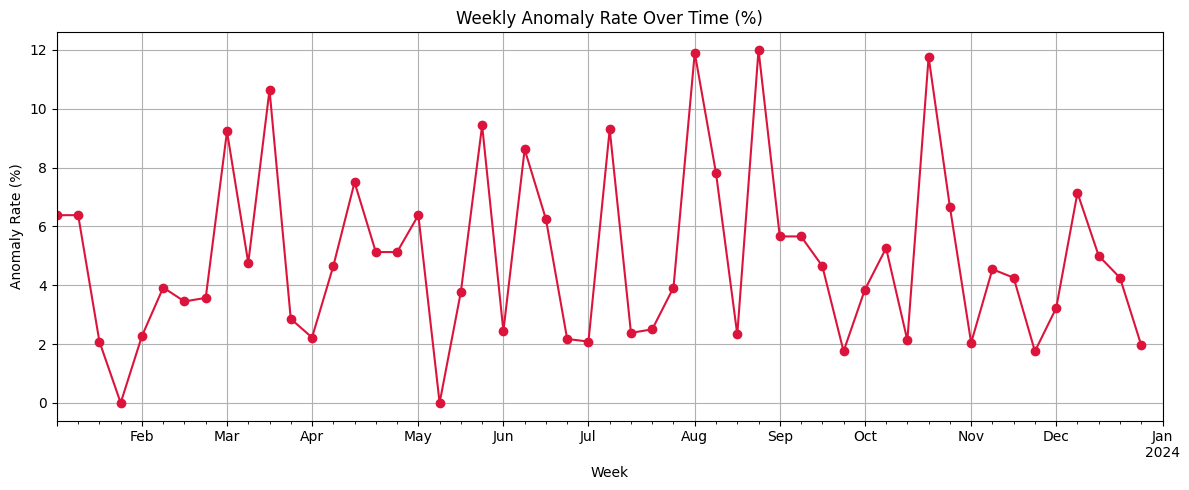

In [57]:
# Reset the index to ensure 'TransactionDate' is a column (Error prevention)
df.reset_index(inplace=True, drop=True)

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df.set_index('TransactionDate', inplace=True)

# Resample by week or day
fraud_over_time = df[df['IsAnomaly']].resample('W').size()
total_over_time = df.resample('W').size()

# Calculate anomaly rate over time
anomaly_rate = (fraud_over_time / total_over_time) * 100

plt.figure(figsize=(12, 5))
anomaly_rate.plot(marker='o', color='crimson')
plt.title('Weekly Anomaly Rate Over Time (%)')
plt.ylabel('Anomaly Rate (%)')
plt.xlabel('Week')
plt.grid(True)
plt.tight_layout()
plt.show()



---

